## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
import sklearn.model_selection
from random import sample
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential,Model
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score


Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
2145,00000563_000.png,No Finding,0,563,65,M,PA,2992,2991,0.143,0.143,NaN,/data/images_001/images/00000563_000.png
20963,00005600_001.png,No Finding,1,5600,56,M,PA,2992,2991,0.143,0.143,NaN,/data/images_003/images/00005600_001.png
4725,00001261_000.png,No Finding,0,1261,58,M,PA,2750,2991,0.143,0.143,NaN,/data/images_001/images/00001261_000.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1:
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)
# Todo

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
50527,00012814_000.png,No Finding,0,12814,51,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_006/images/00012814_000.png
17771,00004808_010.png,Infiltration,10,4808,35,M,AP,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_003/images/00004808_010.png
72281,00017800_009.png,No Finding,9,17800,32,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_008/images/00017800_009.png


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
# Todo
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia']
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path,pneumonia_class
85211,00021006_030.png,Atelectasis,30,21006,71,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_010/images/00021006_030.png,0.0
52043,00013123_010.png,Atelectasis,10,13123,54,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_006/images/00013123_010.png,0.0
104798,00028084_000.png,No Finding,0,28084,27,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_011/images/00028084_000.png,0.0


In [5]:
wo_outliers = all_xray_df[all_xray_df['Patient Age'] < 100].index.tolist()
all_xray_df_mod = all_xray_df.loc[wo_outliers]
all_xray_df_mod.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path,pneumonia_class
68541,00016930_011.png,No Finding,11,16930,25,F,PA,2148,2488,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_008/images/00016930_011.png,0.0
12911,00003388_002.png,No Finding,2,3388,47,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_002/images/00003388_002.png,0.0
49157,00012471_005.png,Emphysema|Infiltration,5,12471,64,M,PA,2834,2989,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_006/images/00012471_005.png,0.0


In [6]:
pneumonia_cases = all_xray_df_mod['pneumonia_class'].value_counts()
pneumonia_cases

0.0    110674
1.0      1430
Name: pneumonia_class, dtype: int64

## Create your training and testing data:

In [7]:
train_df,valid_df = sklearn.model_selection.train_test_split(all_xray_df_mod, test_size=0.2, stratify = all_xray_df_mod['pneumonia_class'])

In [8]:
p_case= train_df[train_df.pneumonia_class == 1].index.tolist()
n_case= train_df[train_df.pneumonia_class == 0].index.tolist()
n_sample = sample(n_case, len(p_case))
train_df = train_df.loc[p_case+n_sample]
train_df['pneumonia_class'].sum()/len(train_df)

0.5

In [9]:
p_case= valid_df[valid_df.pneumonia_class == 1].index.tolist()
n_case= valid_df[valid_df.pneumonia_class == 0].index.tolist()
n_sample = sample(n_case, 3 * len(p_case))
valid_df = valid_df.loc[p_case+n_sample]
valid_df['pneumonia_class'].sum()/len(valid_df)

0.25

In [10]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_df,valid_df = sklearn.model_selection.train_test_split(all_xray_df_mod, test_size=0.2, stratify = all_xray_df_mod['pneumonia_class'])
    
    p_case_t= train_df[train_df.pneumonia_class == 1].index.tolist()
    n_case_t= train_df[train_df.pneumonia_class == 0].index.tolist()
    n_sample_t = sample(n_case_t, len(p_case_t))
    train_data = train_df.loc[p_case_t+n_sample_t]
    train_data['pneumonia_class'] = train_data['pneumonia_class'].astype(str)
    
    p_case= valid_df[valid_df.pneumonia_class == 1].index.tolist()
    n_case= valid_df[valid_df.pneumonia_class == 0].index.tolist()
    n_sample = sample(n_case, 3 * len(p_case))
    valid_data = valid_df.loc[p_case+n_sample]
    valid_data['pneumonia_class'] = valid_data['pneumonia_class'].astype(str)
    return train_data, valid_data

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [11]:
def train_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    train_idg = ImageDataGenerator(rescale=1. / 255.0,
                                   horizontal_flip =True,
                                   vertical_flip = False,
                                   height_shift_range = 0.1,
                                   width_shift_range = 0.1,
                                   rotation_range = 15,
                                   shear_range = 0.1,
                                   zoom_range = 0.1)
    
    return train_idg

def valid_image_augmentation():
    valid_idg = ImageDataGenerator(rescale=1. /255.0)
    
    return valid_idg

def train_generator(train_data):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_idg = train_image_augmentation()
    
    train_gen = train_idg.flow_from_dataframe(dataframe=train_data, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = (224,224), 
                                         batch_size = 44
                                         )
     # Todo

    return train_gen


def valid_generator(valid_data):
    
    valid_idg = valid_image_augmentation()
    
    valid_gen = valid_idg.flow_from_dataframe(dataframe = valid_data, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = (224,224) , 
                                             batch_size = 44)
    return valid_gen
                                              
def valid_generator_full(valid_data):
    valid_idg = valid_image_augmentation()
    
    valid_gen_full = valid_idg.flow_from_dataframe(dataframe = valid_data, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = (224,224),
                                             batch_size = len(valid_data)) 
    return valid_gen_full

In [12]:
train_data, valid_data = create_splits(all_xray_df_mod)
len(train_data)


2288

In [13]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valid_gen = valid_generator(valid_data)
valX, valY = valid_gen.next()
len(valX)

Found 1144 validated image filenames belonging to 2 classes.


44

In [14]:
valid_gen_full = valid_generator_full(valid_data)
valX_full, valY_full = valid_gen_full.next()
len(valX_full)

Found 1144 validated image filenames belonging to 2 classes.


1144

Found 2288 validated image filenames belonging to 2 classes.


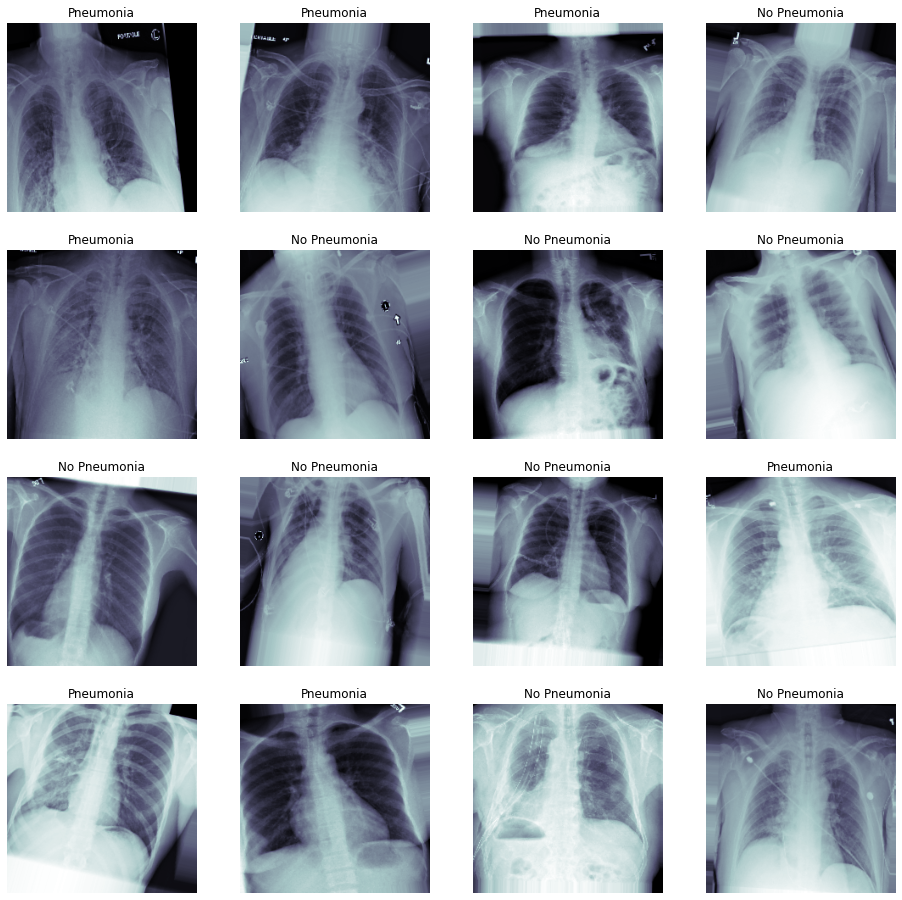

In [15]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation
train_gen = train_generator(train_data)

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [16]:
model = VGG16(include_top=True, weights='imagenet')

In [17]:
def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    return vgg_model


In [18]:
def build_my_model():
    
    my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    my_model.add(load_pretrained_model())
    
    my_model.add(Flatten())
    
    my_model.add(Dropout(0.5))
    
    my_model.add(Dense(1024, activation = 'relu'))
    
    my_model.add(Dropout(0.5))
    
    my_model.add(Dense(512, activation = 'relu'))
    
    my_model.add(Dropout(0.5))
    
    my_model.add(Dense(256, activation = 'relu'))
    
    my_model.add(Dropout(0.5))
    
    my_model.add(Dense(128, activation = 'relu'))
    
    my_model.add(Dense(1,activation = 'sigmoid'))
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    optimizer = Adam(lr=1e-3)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [19]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_binary_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'auto', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_binary_accuracy', 
                      mode= 'auto', 
                      patience=15)

callbacks_list = [checkpoint, early]

### Start training! 

In [20]:
## train your model
my_model = build_my_model()
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 25, 
                          callbacks = callbacks_list)

Epoch 1/25
52/52 [==============================] - 67s 1s/step - loss: 0.7979 - binary_accuracy: 0.5026 - val_loss: 0.6766 - val_binary_accuracy: 0.6818

Epoch 00001: val_binary_accuracy improved from -inf to 0.68182, saving model to xray_class_my_model.best.hdf5
Epoch 2/25
52/52 [==============================] - 57s 1s/step - loss: 0.6907 - binary_accuracy: 0.5551 - val_loss: 0.6571 - val_binary_accuracy: 0.6136

Epoch 00002: val_binary_accuracy did not improve from 0.68182
Epoch 3/25
52/52 [==============================] - 58s 1s/step - loss: 0.6871 - binary_accuracy: 0.5656 - val_loss: 0.6589 - val_binary_accuracy: 0.5682

Epoch 00003: val_binary_accuracy did not improve from 0.68182
Epoch 4/25
52/52 [==============================] - 58s 1s/step - loss: 0.6809 - binary_accuracy: 0.5695 - val_loss: 0.7785 - val_binary_accuracy: 0.3864

Epoch 00004: val_binary_accuracy did not improve from 0.68182
Epoch 5/25
52/52 [==============================] - 57s 1s/step - loss: 0.6843 - bin

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [21]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX_full, batch_size = 128, verbose = True)

1144/1144 [==============================] - 21s 18ms/step


In [22]:
def plot_auc(t_y, p_y):
    
    fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(t_y, p_y)
    
    # Calculate AUC
    auc_score = roc_auc_score(t_y, p_y)
    
    # Plot ROC curve
    c_ax.plot(fpr, tpr, label='%s (AUC: %0.2f)' % ('Pneumonia', auc_score))
    c_ax.plot([0, 1], [0, 1], linestyle='--')  # Add a reference line for random chance
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.show()

## what other performance statistics do you want to include here besides AUC? 


# def ...
def plot_precision_recall_curve(t_y, p_y):


    fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
    
    # Calculate precision-recall curve
    precision, recall, _ = precision_recall_curve(t_y, p_y)
    
    # Calculate Average Precision Score
    ap_score = average_precision_score(t_y, p_y)
    
    # Plot Precision-Recall curve
    c_ax.plot(recall, precision, label='%s (AP Score: %0.2f)' % ('Pneumonia', ap_score))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
# Todo

# def ...
# function to calculate the F1 score
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    return

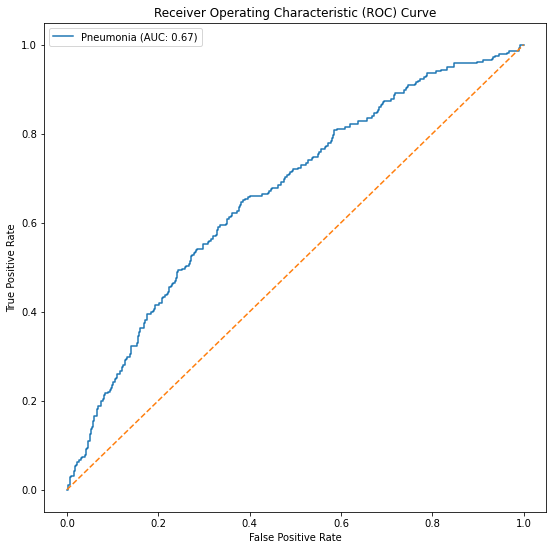

In [23]:
## plot figures
plot_auc(valY_full, pred_Y)
# Todo

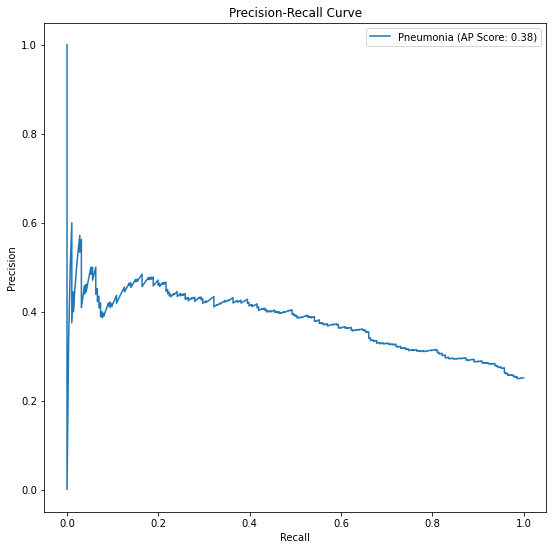

In [24]:
plot_precision_recall_curve(valY_full, pred_Y)

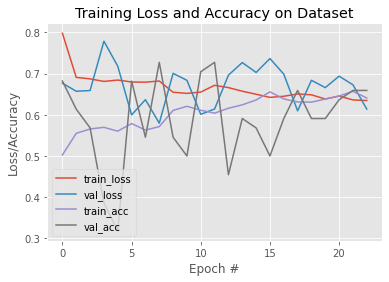

In [25]:
plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [26]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
YOUR_THRESHOLD = 0.5

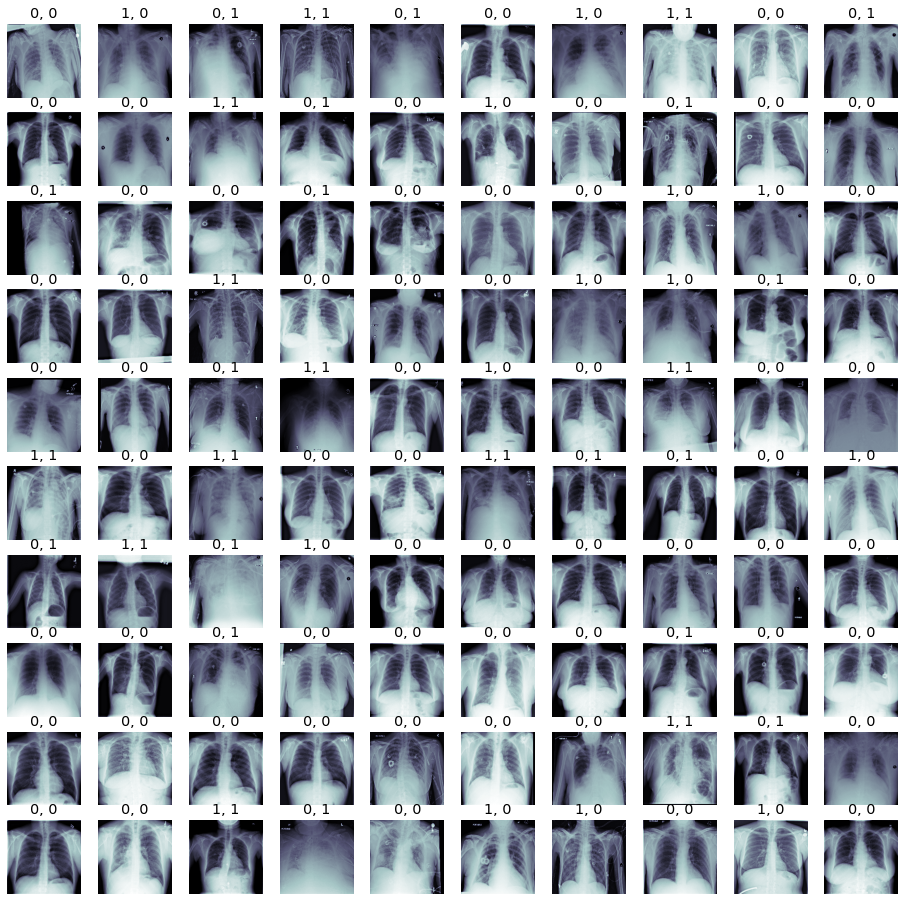

In [27]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX_full[0:100], valY_full[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [28]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)